In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
customers = pd.read_csv('customers.csv')
customers.rename(columns={"id": "customer_id"}, inplace=True)
customers.head()

,customer_id,name,segment,state,city
0,CG-12520,Claire Gute,Consumer,Kentucky,Henderson
1,DV-13045,Darrin Van Huff,Corporate,California,Los Angeles
2,SO-20335,Sean O'Donnell,Consumer,Florida,Fort Lauderdale
3,BH-11710,Brosina Hoffman,Consumer,California,Los Angeles
4,AA-10480,Andrew Allen,Consumer,North Carolina,Concord


In [20]:
orders = pd.read_csv('orders.csv')
orders

,id,order_date,ship_mode,customer_id,sales
0,100006,2014-09-07,Standard,DK-13375,377.970
1,100090,2014-07-08,Standard,EB-13705,699.192
2,100293,2014-03-14,Standard,NF-18475,91.056
3,100328,2014-01-28,Standard,JC-15340,3.928
4,100363,2014-04-08,Standard,JM-15655,21.376
...,...,...,...,...,...
5004,168802,2017-11-03,Standard,JO-15145,18.368
5005,169320,2017-07-23,Second,LH-16900,171.430
5006,169488,2017-09-07,First,AA-10375,56.860
5007,169502,2017-08-28,Standard,MG-17650,113.410


In [5]:
import datetime as dt
data = customers.merge(orders, how='inner', on = 'customer_id')[['customer_id', 'id', 'ship_mode', 'sales', 'order_date']]
data['order_date'] = pd.to_datetime(data['order_date'])
data['order_date'] = data['order_date'].apply(lambda x: dt.datetime(x.year, x.month, 1))
data['first_order_date'] = data.groupby('customer_id')['order_date'].transform('min')

In [19]:
data[data['first_order_date'].dt.year ==2014]

,customer_id,id,ship_mode,sales,order_date,first_order_date,cohort
14,BH-11710,115812,Standard,3714.3040,2014-06-01,2014-06-01,1
15,BH-11710,149300,First,32.9850,2015-11-01,2014-06-01,18
16,BH-11710,112123,Standard,1094.2500,2016-03-01,2014-06-01,22
17,BH-11710,112865,Standard,36.0480,2017-05-01,2014-06-01,36
18,BH-11710,127306,Standard,175.0860,2017-01-01,2014-06-01,32
...,...,...,...,...,...,...,...
4985,CM-12715,133585,First,1283.3264,2015-03-01,2014-03-01,13
4999,HD-14785,119172,Standard,122.0520,2014-05-01,2014-05-01,1
5000,HD-14785,157343,Standard,52.2480,2015-06-01,2014-05-01,14
5001,HD-14785,162376,Second,77.0600,2015-11-01,2014-05-01,19


In [6]:
difference_year = data.order_date.dt.year - data.first_order_date.dt.year
difference_month = data.order_date.dt.month - data.first_order_date.dt.month
data['cohort'] = difference_year * 12 + difference_month + 1

cohort_data = data.groupby(['first_order_date','cohort'])['customer_id'].apply(pd.Series.nunique).reset_index()
cohort_table = cohort_data.pivot(index='first_order_date', columns=['cohort'],values='customer_id')
cohort_table.index = cohort_table.index.strftime('%B %Y')
cohort_table_perc = cohort_table.divide(cohort_table.iloc[:,0], axis=0)

## Ответ

### Снизу количество уникальных пользователей разбитых по когортам
#### Видно, что бОльшая часть пришла в 2014 году 

<AxesSubplot:xlabel='cohort', ylabel='first_order_date'>

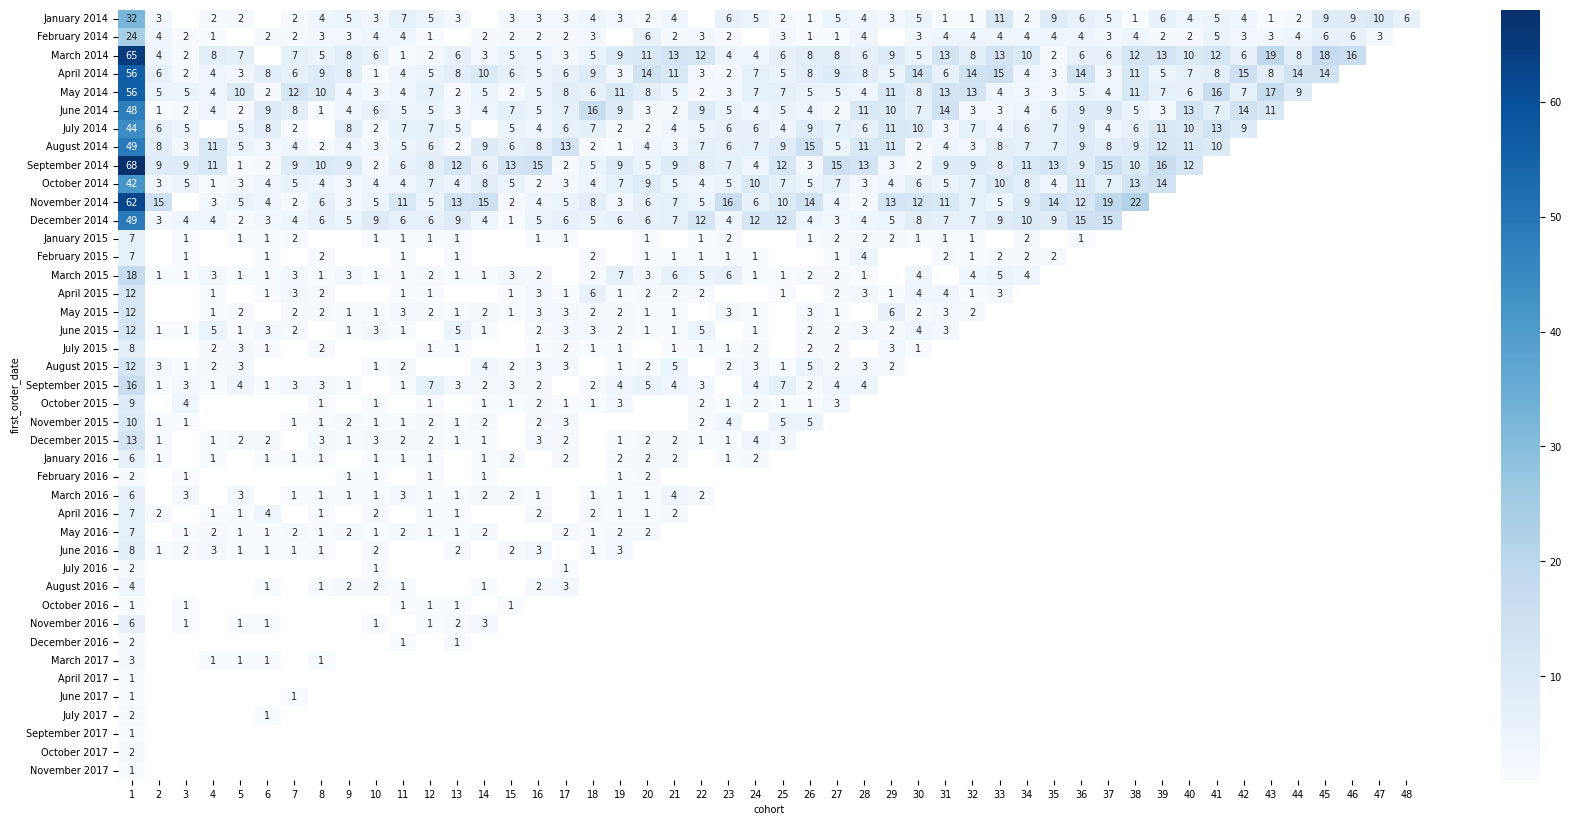

In [7]:
plt.figure(figsize=(21,10))
plt.rcParams.update({'font.size': 7})
sns.heatmap(cohort_table, annot=True, cmap='Blues')

### Здесь табичка конверсий, видно что присутствует некая сезонность

<AxesSubplot:xlabel='cohort', ylabel='first_order_date'>

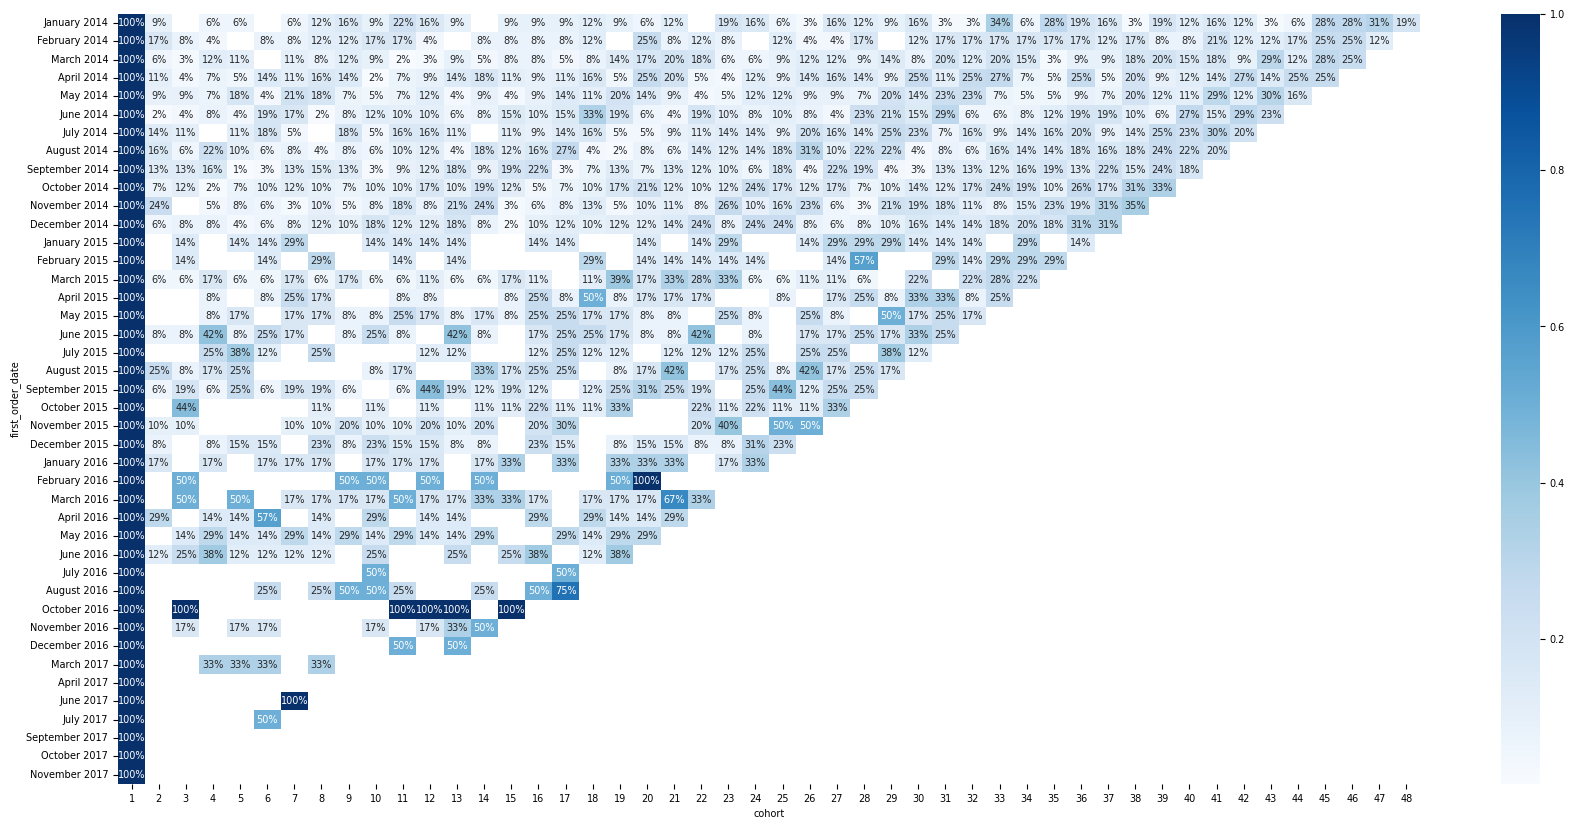

In [8]:
plt.figure(figsize=(21,10))
plt.rcParams.update({'font.size': 7})
sns.heatmap(cohort_table_perc, annot=True, fmt='.0%', cmap='Blues')

In [9]:
perc =np.array(cohort_table_perc)

In [10]:
month_retention_14_16 = []
for i in range(24, 36):
    ret = 0 
    for j in range(12):
        if np.isnan(perc[j, i - j]):
            ret += 0
        else:
            ret += perc[j, i - j]
    month_retention_14_16.append(ret / 12)

month_retention_14_17 = []
for i in range(36, 48):
    ret = 0 
    for j in range(12):
        if np.isnan(perc[j, i - j]):
            ret += 0
        else:
            ret += perc[j, i - j]
    month_retention_14_17.append(ret / 12)


In [15]:
month_retention_15_16 = []
for i in range(24, 36):
    ret = 0 
    for j in range(13, 25):
        if np.isnan(perc[j, i - j]):
            ret += 0
        else:
            ret += perc[j, i - j]
    month_retention_15_16.append(ret / 12)

month_retention_15_17 = []
for i in range(13, 25):
    ret = 0 
    for j in range(12):
        if np.isnan(perc[j, i - j]):
            ret += 0
        else:
            ret += perc[j, i - j]
    month_retention_15_17.append(ret / 12)

### Так как большинство пользователей пришло в 2014, то сравнивать конверсии 2016 и 2017 годов по ним, чтоб не зашумлять результаты 
#### Снизу средняя конверсия по месяцам из 2016 и 2017 годов по пользователям, которые совершили первую покупку в 2014

<AxesSubplot:title={'center':'Avg conversion'}>

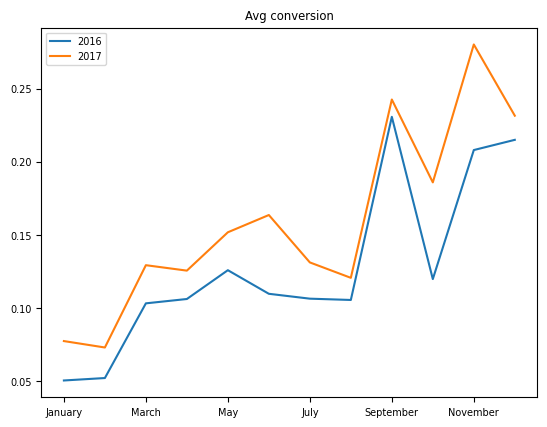

In [14]:
index = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
df = pd.DataFrame({
    '2016':month_retention_14_16,
    '2017':month_retention_14_17, 
},
index = index
)
df.plot(kind='line', title='Avg conversion')

### Ну собственно средняя конверсия стабильно выше в 2017 году. Беда в том, что количество новых клиентов с каждым годом падает, но задача вроде не об этом 